In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Feature Engineering
from sklearn.preprocessing import PolynomialFeatures, normalize, StandardScaler
from sklearn.compose import make_column_transformer
from scipy.signal import medfilt

# Classifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Parameter Search
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split,cross_val_score


# Time series functions
from tsfresh.feature_extraction.feature_calculators import number_peaks, mean_abs_change, abs_energy, absolute_sum_of_changes, cid_ce

# accuracy metrics
from sklearn.metrics import roc_curve, recall_score,precision_score,roc_auc_score,average_precision_score,precision_recall_curve, confusion_matrix
from sklearn.metrics import f1_score, auc

# Paralell processing
from dask.distributed import Client, progress
import dask


/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# import datasets
feat_data0 = pd.read_csv('features/part-00000-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
feat_data1 = pd.read_csv('features/part-00001-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
feat_data2 = pd.read_csv('features/part-00002-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
feat_data3 = pd.read_csv('features/part-00003-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
feat_data4 = pd.read_csv('features/part-00004-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
feat_data5 = pd.read_csv('features/part-00005-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
feat_data6 = pd.read_csv('features/part-00006-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
feat_data7 = pd.read_csv('features/part-00007-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
feat_data8 = pd.read_csv('features/part-00008-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
feat_data9 = pd.read_csv('features/part-00009-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
labels = pd.read_csv('labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

In [3]:
# combine datasets
feat_data = pd.concat([feat_data0, feat_data1, feat_data2, feat_data3, feat_data4, feat_data5, feat_data6, feat_data7, feat_data8, feat_data9], ignore_index=True)

In [4]:
feat_data.shape

(16135561, 11)

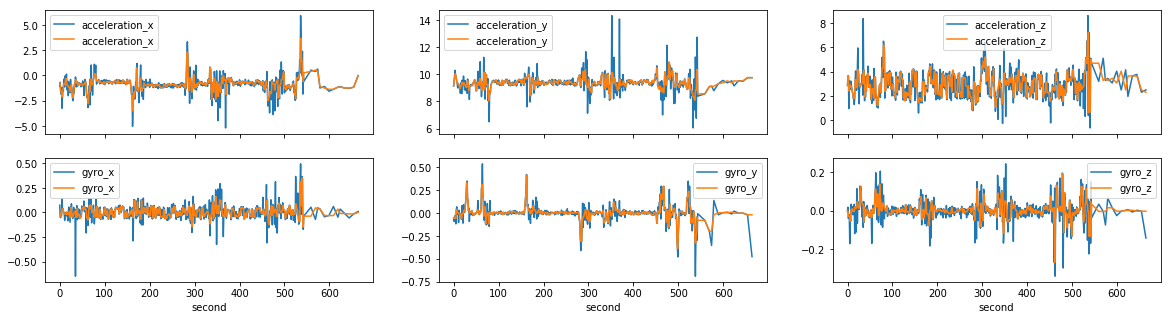

In [7]:
# Sample sensor data for TRUE target
fig, axs = plt.subplots(2, 3, sharex=True )

true_target = feat_data[feat_data['bookingID'] == 274877906944].sort_values('second')
true_target.plot(x='second', y='acceleration_x', ax=axs[0,0], figsize=(20,5))
true_target.plot(x='second', y='acceleration_y', ax=axs[0,1])
true_target.plot(x='second', y='acceleration_z', ax=axs[0,2])
true_target.plot(x='second', y='gyro_x', ax=axs[1,0])
true_target.plot(x='second', y='gyro_y', ax=axs[1,1])
true_target.plot(x='second', y='gyro_z', ax=axs[1,2])


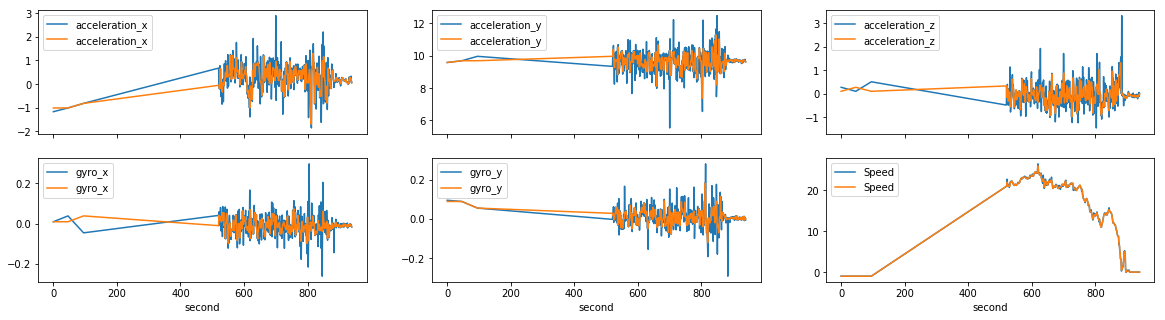

In [9]:
# Sample sensor data for false target
fig, axs = plt.subplots(2, 3, sharex=True )

false_target = feat_data[feat_data['bookingID'] == 171798691856].sort_values('second')
false_target.plot(x='second', y='acceleration_x', ax=axs[0,0], figsize=(20,5))
false_target.plot(x='second', y='acceleration_y', ax=axs[0,1])
false_target.plot(x='second', y='acceleration_z', ax=axs[0,2])
false_target.plot(x='second', y='gyro_x', ax=axs[1,0])
false_target.plot(x='second', y='gyro_y', ax=axs[1,1])
false_target.plot(x='second', y='Speed', ax=axs[1,2])

In [5]:
# exclude 82 rows with second larger than 1000000s (outliers)
feat_data = feat_data[feat_data['second'] < 10000]

# filter data (2%) which accuracy too low and far from meaningful
feat_data = feat_data[feat_data['Accuracy'] < 30]

In [2]:
feat_data = pd.read_csv('feat_data_outlier_cleaned')

In [8]:
def filter_normalise_signal(df):
  sensor_columns = ['acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y','gyro_z','Speed']
  sc = StandardScaler(with_std=False)
  for col in sensor_columns:
    # apply median filter
    df[col] = medfilt(df[col])
    # normalize signal
    df[col] = sc.fit_transform(df[[col]])
  return df

def polynomial_features(df, columns):
  poly_df = df[columns]
  poly = PolynomialFeatures(degree=2, include_bias=False)
  poly.fit(poly_df)
  poly_df = poly.transform(poly_df)
  poly_names = poly.get_feature_names(input_features = columns)
  poly_df = pd.DataFrame(poly_df, columns = poly_names)
  
  # merge 
  df = df[df.columns[~df.columns.isin(columns)]]
  df.reset_index(drop=True, inplace=True)
  df = pd.concat([df, poly_df], axis = 1)
    
  return df

def calculate_feature_stats(bookingID):
  curr_book_data = feat_data[feat_data['bookingID'] == bookingID].sort_values('second')
  
  # filter and normalize sensor signal  
  curr_book_data = filter_normalise_signal(curr_book_data)
  
  row = list()
  row.append(str(bookingID))
  
  # loop through all columns
  for col in curr_book_data.columns.drop(['bookingID','second','Accuracy', 'Bearing']):
    # create rows
    row.append(curr_book_data[col].min())
    row.append(curr_book_data[col].max())
    row.append(curr_book_data[col].std(ddof=0))
    row.append(curr_book_data[col].mean())
    row.append(curr_book_data[col].median())
    row.append(curr_book_data[col].quantile(0.25))
    row.append(curr_book_data[col].quantile(0.5))
    row.append(curr_book_data[col].quantile(0.75))
    row.append(curr_book_data[col].var(ddof=0))
    row.append(int(curr_book_data[col].shape[0]))
    row.append(curr_book_data[col].sum())
    row.append(mean_abs_change(curr_book_data[col]))
    row.append(abs_energy(curr_book_data[col]))  # sum of squared data
    row.append(absolute_sum_of_changes(curr_book_data[col]))  # absolute sum of changes between t and t-1
    row.append(cid_ce(curr_book_data[col], False)) # calculate data complexity based on peaks, valleys etc.
    row.append(number_peaks(curr_book_data[col], 3))  # number of peaks supported by n data points
    
  return row

def generate_feature_stat_columns(df):
  columns = ['bookingID']
  for col in df.columns.drop(['bookingID','second','Accuracy', 'Bearing']):
    columns.append('%s_min' % col)
    columns.append('%s_max' % col)
    columns.append('%s_std' % col)
    columns.append('%s_mean' % col)
    columns.append('%s_median' % col)
    columns.append('%s_q25' % col)
    columns.append('%s_q50' % col)
    columns.append('%s_q75' % col)
    columns.append('%s_var' % col)
    columns.append('%s_length' % col)
    columns.append('%s_sum' % col)
    columns.append('%s_mean_abs_change' % col)
    columns.append('%s_abs_energy' % col)
    columns.append('%s_abs_sum_change' % col)
    columns.append('%s_cid_ce' % col)
    columns.append('%s_num_peaks' % col)
    
  return columns

# feature selection using random forest
def rf_feat_select(X,y):
  rf_classifier = RandomForestClassifier(n_jobs = -1,random_state=0)
  rf_classifier.fit(X, y)
  
  return X.columns, normalize([rf_classifier.feature_importances_])[0,:]

In [ ]:
import time
calculate_feature_stats = dask.delayed(calculate_feature_stats)


start = time.time()
rows = []
bookingIdList = feat_data['bookingID'].unique().tolist()
for bookingID in bookingIdList:
    row = calculate_feature_stats(bookingID)
    rows.append(row)

# compute features in parallel
rows = dask.persist(*rows)
data = np.array([row.compute() for row in rows])

# create dataframe from extracted features
columns = generate_feature_stat_columns(feat_data)
extract_features = pd.DataFrame(data, columns = columns, dtype=float)

end = time.time()
print(end - start)

In [54]:
# fill 0 for NA in mean abs change
extract_features.fillna(0,inplace=True)

In [55]:
# remove booking ID with conflicting labels 
conflictIds = labels[labels['bookingID'].duplicated()]['bookingID']
features = extract_features[~extract_features['bookingID'].isin(conflictIds.apply(str))]

In [56]:
# adding label to extracted features
features['TARGET'] = features['bookingID'].apply(lambda x: labels[labels['bookingID'] == int(x)]['label'].item() )

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
# split feature and target
bookingIds = features['bookingID']
y = features['TARGET']
X = features.drop(['bookingID', 'TARGET'], axis = 1)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


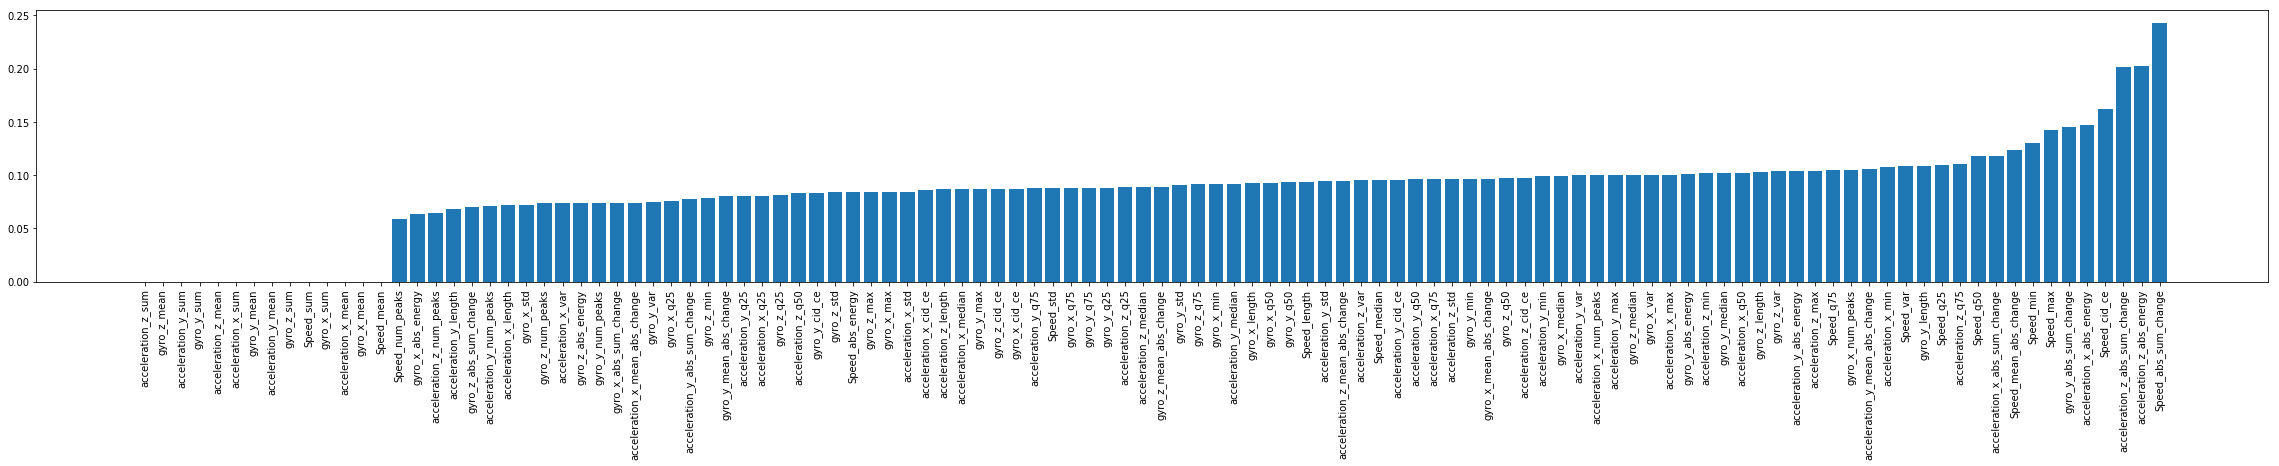

In [58]:
# run feature selection
feats, feat_imp = rf_feat_select(X,y)

feats = feats.tolist()

# sort 
indices = np.argsort(feat_imp)
feat_x = [feats[i] for i in indices]
feat_y = [feat_imp[i] for i in indices]

f, ax = plt.subplots(figsize=(40,5))
plt.bar(feat_x, feat_y)
_ = plt.xticks(rotation='vertical')

In [66]:
# drop 14 non relevant features
X = X[feat_x[14:]]

In [68]:
# Create polynomial features for 4 most relevant features
X_poly = polynomial_features(X, feat_x[-4:])

In [69]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2, random_state = 0)

In [70]:
# build gradient boosting model
xgbclassifier = XGBClassifier( n_jobs = 5, random_state = 1, objective = 'binary:logistic',
                                eval_metric = 'auc', 
                                booster = 'gbtree',
                                early_stopping_round = 20,
                                verbosity = 1
                                )

scores = cross_val_score(estimator = xgbclassifier, X = X_train , y = y_train , cv = 4, n_jobs = 5, scoring="roc_auc" )
print("mean = ",round(scores.mean(),2)," std =",round(scores.std(),2))

mean =  0.7  std = 0.01


In [ ]:
# bayes optimization search
opt = BayesSearchCV(
    xgbclassifier,
    {
        'n_estimators': [100, 500, 1000, 1500, 2000],
    },
    n_iter=50,
    cv=4,
    scoring='roc_auc',
    n_jobs = 6
)

# callback handler
def on_step(optim_result):
    score = opt.best_score_
    params = opt.best_params_
    print("best score: %s and params: %s" % (score, params))
    if score >= 0.99:
        print('Interrupting!')
        return True
    
opt.fit(X_train, y_train, callback=on_step)

In [71]:
# training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 50)
xgbclassifier.fit(X_train, y_train)
y_pred = xgbclassifier.predict(X_val)
y_pred_probs = xgbclassifier.predict_proba(X_val)
cm = confusion_matrix(y_val, y_pred)
print("Validation cm :", cm)

# predict test
y_test_pred = xgbclassifier.predict(X_test)
y_test_probs = xgbclassifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_test_pred)
print("Test cm :",cm)

Validation cm : [[2339   67]
 [ 646  141]]
Test cm : [[2941   66]
 [ 815  169]]


AUC: 0.70


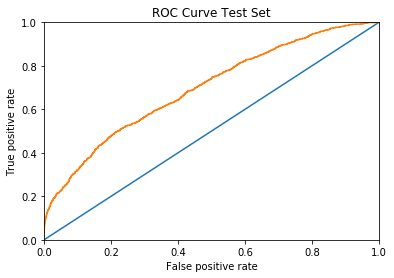

In [72]:
auc = roc_auc_score(y_test, y_test_probs)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.title("ROC Curve Test Set")
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr)
plt.show()